# COMPUTER VISION 2024 PROJECT

## Imports

In [59]:
import numpy as np
import matplotlib.pyplot as plt

import os
from datetime import datetime
import copy
import random
from tqdm import trange
from rich import print

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OutputCodeClassifier

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image

from utils.training_utils import *
from utils.svm_utils import *
from utils.plot_utils import *
from utils.images_utils import *

# for reproducibility
torch.manual_seed(52370920013135234)

DEVICE: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EARLY_STOPPING = 15

## Load images

In [60]:
# retrieve cnn and alexnet datasets
data = prepare_images()

In [61]:
X_train, y_train, X_val, y_val, X_test, y_test = data[0]

train_dataset = ImageDataset(images=X_train, labels=y_train)
val_dataset = ImageDataset(images=X_val, labels=y_val)
test_dataset = ImageDataset(images=X_test, labels=y_test)

loaders = build_loaders(train_dataset, val_dataset, test_dataset)
test_loader = loaders[-1]

In [62]:
# Create datasets
alex_X_train, alex_y_train, alex_X_val, alex_y_val, alex_X_test, alex_y_test = data[1]

alex_train_dataset = ImageDataset(images=alex_X_train, labels=alex_y_train)
alex_val_dataset = ImageDataset(images=alex_X_val, labels=alex_y_val)
alex_test_dataset = ImageDataset(images=alex_X_test, labels=alex_y_test)

alex_loaders = build_loaders(alex_train_dataset, alex_val_dataset, alex_test_dataset)
alex_test_loader = alex_loaders[-1]

# First Point

Implementation of standard provided model trained with SDG and library's standard parameters.

In [5]:
simple_model = CNN()
simple_model.apply(initialize_weights)
simple_model.to(DEVICE)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(simple_model.parameters()) # standard parameters

losses, accuracies = training(simple_model, loaders, optimizer, loss_function, num_epochs=100, early_stopper=EarlyStopping(EARLY_STOPPING))

 72%|███████▏  | 72/100 [00:19<00:07,  3.77it/s]


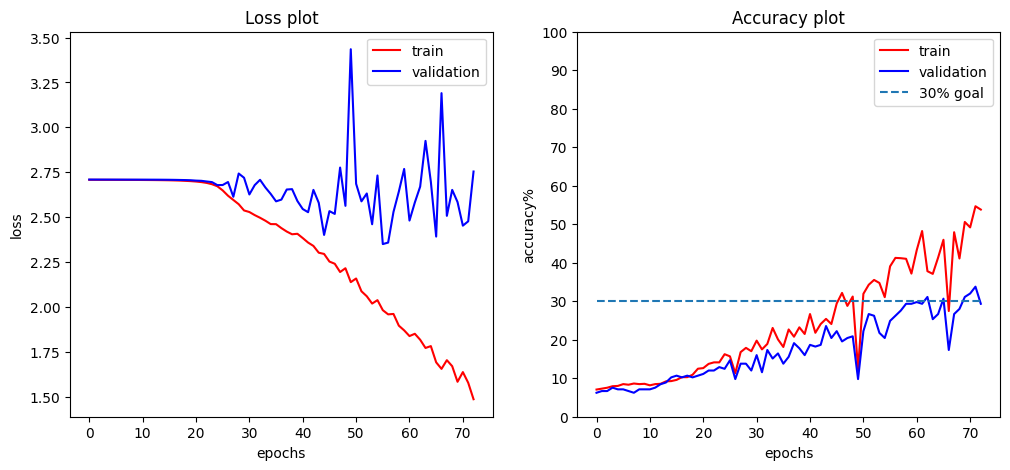

In [6]:
plot_data(losses, accuracies, goals=[30])

TEST ACCURACY IS: 27.44%

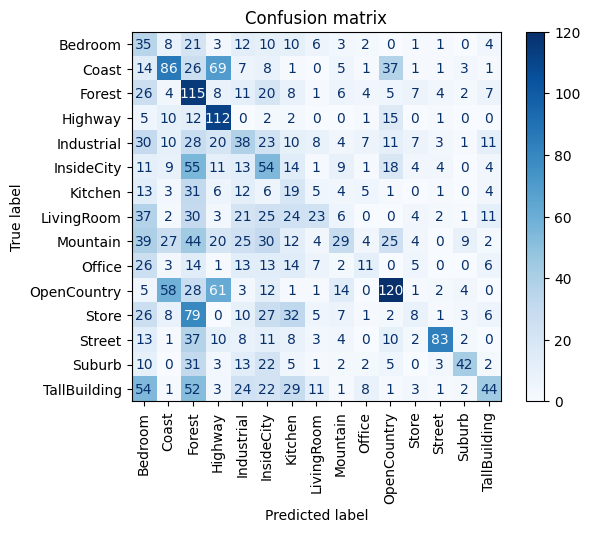

In [7]:
test_accuracy, y_hat = compute_accuracy(simple_model, test_loader, DEVICE)

print(f'TEST ACCURACY IS: {test_accuracy/100:.2%}')
plot_confusion(test_loader.dataset[:][1], y_hat)

# SECOND POINT

Changes to the setting of the first point:
- data augmentation with horizontal flip
- batch normalization
- change size of conv filters: 5x5, 7x7
- change optimization parameters and optimizer
- dropout
- ensemble of networks trained independently

## Data augmentation

We augment the data with an horizontal random flip.

In [8]:
# augmented train loader

flip_transform = transforms.Compose([transforms.RandomHorizontalFlip(0.5)])
aug_train_dataset = ImageDataset(X_train, y_train, transform=flip_transform)
aug_train_loader = DataLoader(aug_train_dataset, batch_size=32, shuffle=True)

loaders = [aug_train_loader, *loaders[1:]]

In [13]:
model = CNN()
model.apply(initialize_weights)
model.to(DEVICE)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), momentum=0.5)

losses, accuracies = training(model, loaders, optimizer, loss_function, num_epochs=100, early_stopper=EarlyStopping(EARLY_STOPPING))

 55%|█████▌    | 55/100 [00:17<00:14,  3.11it/s]


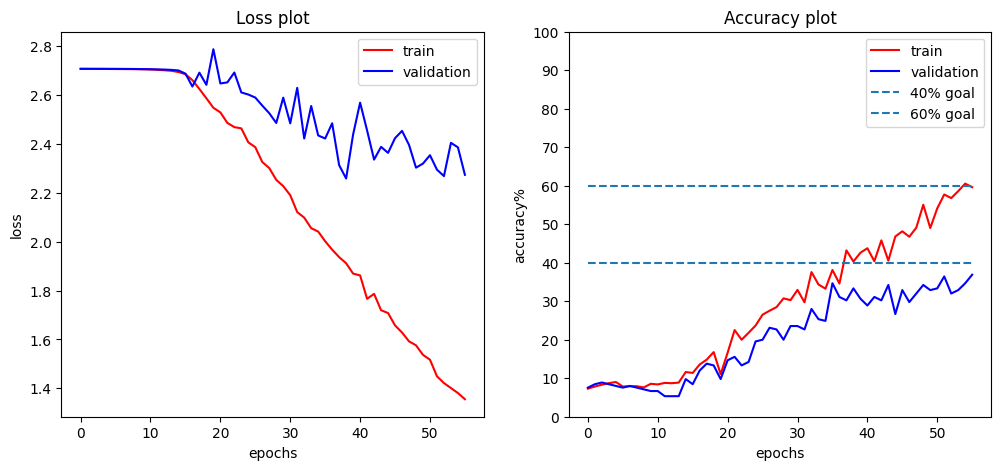

In [14]:
plot_data(losses, accuracies)

TEST ACCURACY IS: 36.78%

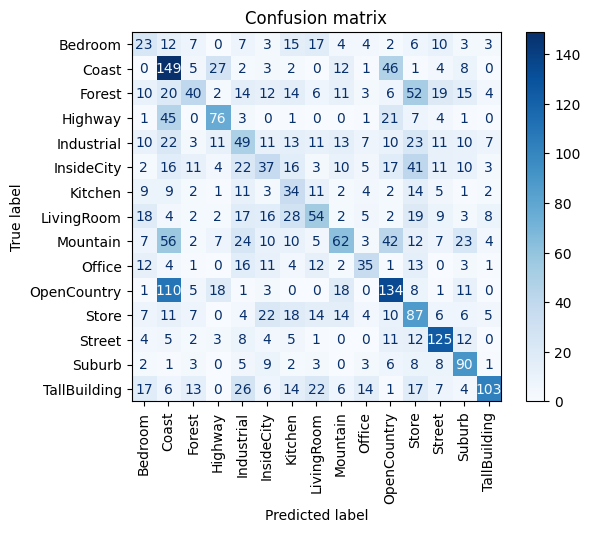

In [16]:
test_accuracy, y_hat = compute_accuracy(model, loaders[-1], DEVICE)

print(f'TEST ACCURACY IS: {test_accuracy/100:.2%}')
plot_confusion(loaders[-1].dataset[:][1], y_hat)

## Batch normalization

In [17]:
model = CNN(batch_norm=True)
model.apply(initialize_weights)
model.to(DEVICE)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters())

losses, accuracies = training(model, loaders, optimizer, loss_function, num_epochs=100, early_stopper=EarlyStopping(EARLY_STOPPING), device=DEVICE)

 82%|████████▏ | 82/100 [00:30<00:06,  2.73it/s]


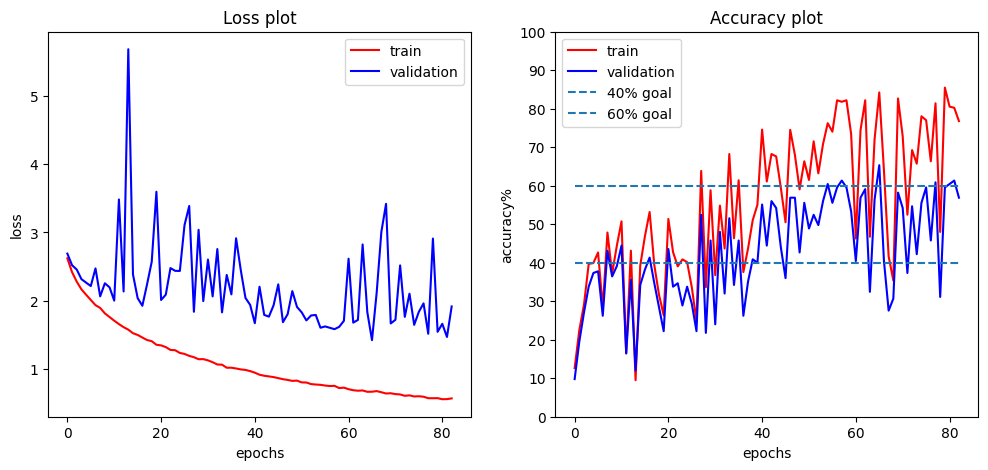

In [18]:
plot_data(losses, accuracies)

TEST ACCURACY IS: 54.740368509212736%

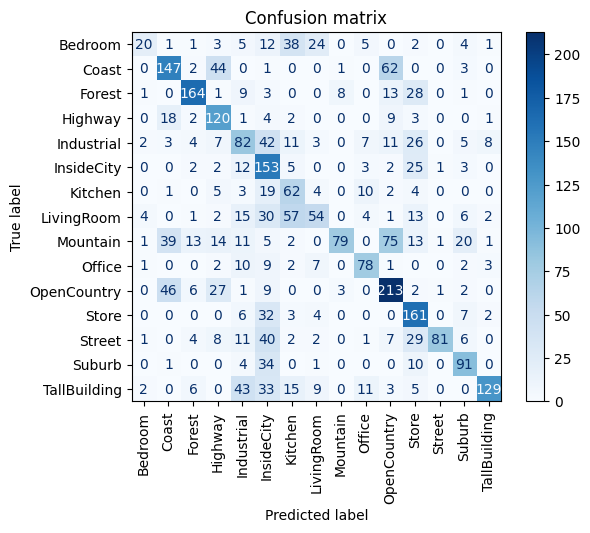

In [20]:
test_accuracy, y_hat = compute_accuracy(model, test_loader, DEVICE)

print(f'TEST ACCURACY IS: {test_accuracy}%')
plot_confusion(test_loader.dataset[:][1], y_hat)

## Size of convolutional filters

Filters of size 5

In [21]:
model = CNN(kernel_size=5, batch_norm=True)
initialize_weights(model.network)
model.to(DEVICE)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters())

losses, accuracies = training(model, loaders, optimizer, loss_function, num_epochs=100, early_stopper=EarlyStopping(EARLY_STOPPING), device=DEVICE)

100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


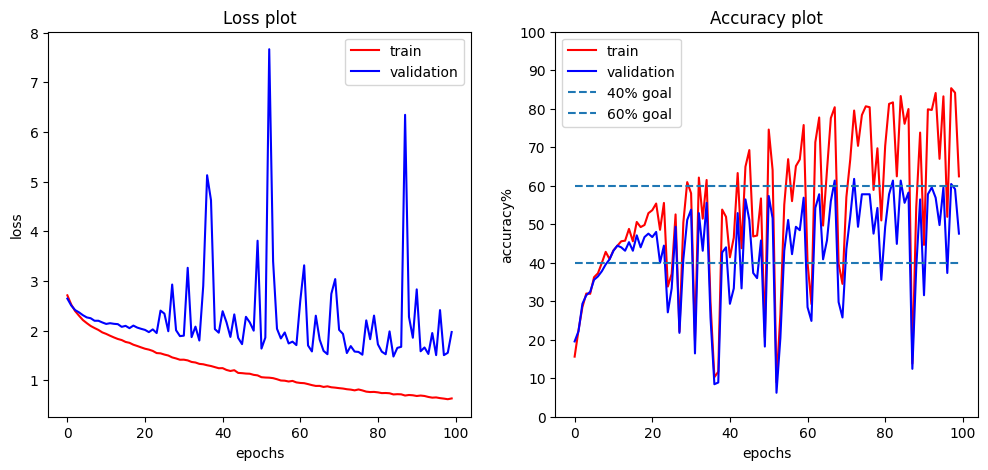

In [22]:
plot_data(losses, accuracies)

TEST ACCURACY IS: 44.56%

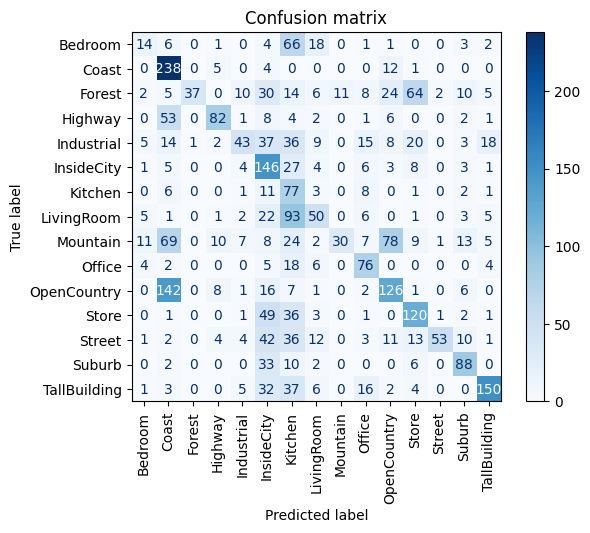

In [24]:
test_accuracy, y_hat = compute_accuracy(model, test_loader, DEVICE)

print(f'TEST ACCURACY IS: {test_accuracy/100:.2%}')
plot_confusion(test_loader.dataset[:][1], y_hat)

kernel = 7

In [25]:
model = CNN(kernel_size=7, batch_norm=True)
initialize_weights(model.network)
model.to(DEVICE)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters())

losses, accuracies = training(model, loaders, optimizer, loss_function, num_epochs=100, early_stopper=EarlyStopping(EARLY_STOPPING), device=DEVICE)

 88%|████████▊ | 88/100 [00:38<00:05,  2.31it/s]


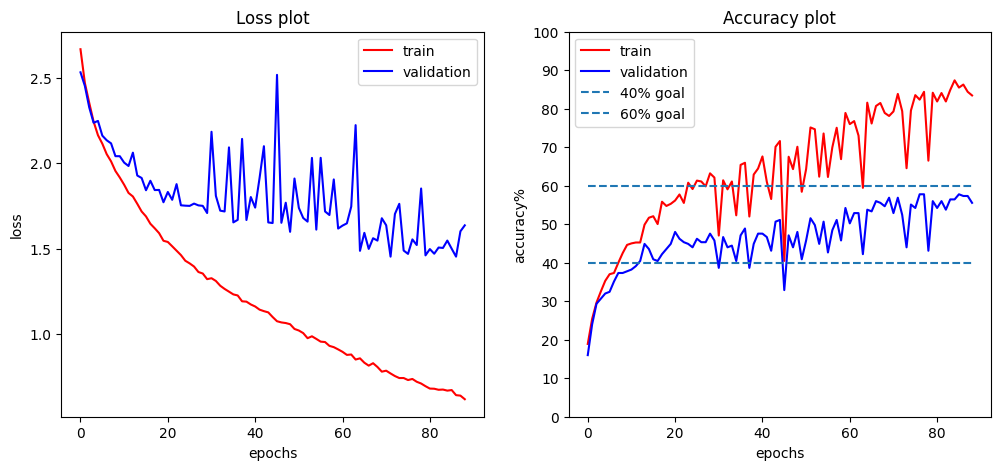

In [26]:
plot_data(losses, accuracies)

TEST ACCURACY IS: 55.44%

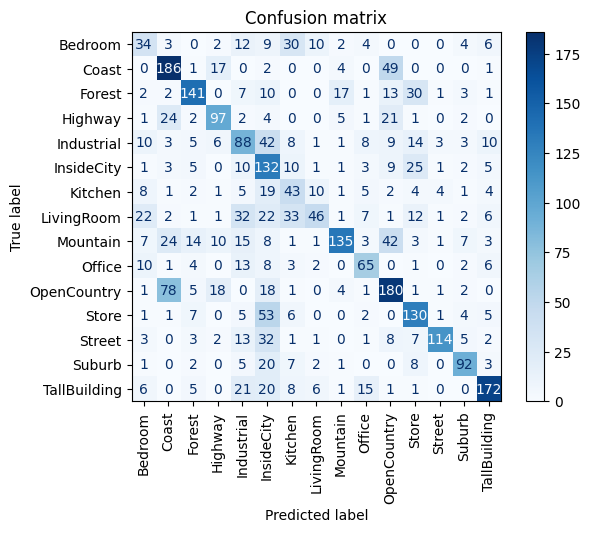

In [27]:
test_accuracy, y_hat = compute_accuracy(model, test_loader, DEVICE)

print(f'TEST ACCURACY IS: {test_accuracy/100:.2%}')
plot_confusion(test_loader.dataset[:][1], y_hat)

## Optimization parameters

Changing the parameters of SDG

In [29]:
model = CNN(kernel_size=3, batch_norm=True)
initialize_weights(model.network)
model.to(DEVICE)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

losses, accuracies = training(model, loaders, optimizer, loss_function, num_epochs=100, early_stopper=EarlyStopping(EARLY_STOPPING), device=DEVICE)

 35%|███▌      | 35/100 [00:12<00:23,  2.73it/s]


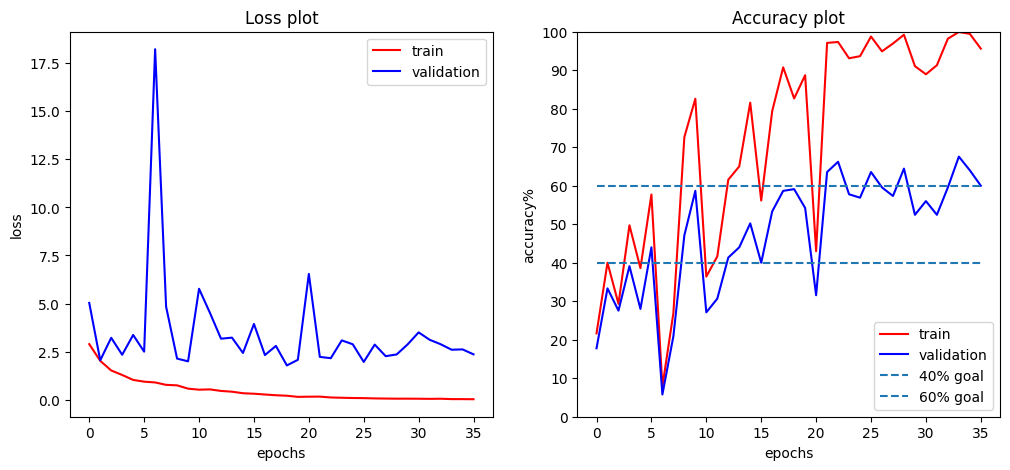

In [34]:
plot_data(losses, accuracies, goals=[40, 60])

TEST ACCURACY IS: 53.57%

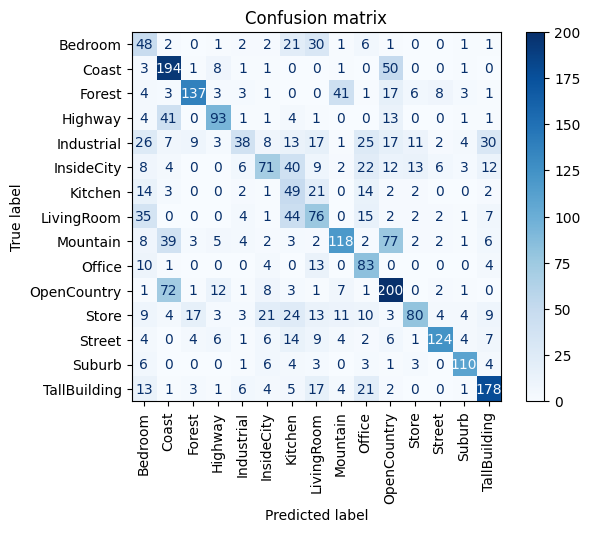

In [32]:
test_accuracy, y_hat = compute_accuracy(model, test_loader, DEVICE)

print(f'TEST ACCURACY IS: {test_accuracy/100:.2%}')
plot_confusion(test_loader.dataset[:][1], y_hat)

Using ADAM optimizer

In [35]:
model = CNN(kernel_size=5, batch_norm=True)
initialize_weights(model.network)
model.to(DEVICE)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

losses, accuracies = training(model, loaders, optimizer, loss_function, num_epochs=100, early_stopper=EarlyStopping(EARLY_STOPPING), device=DEVICE)

 43%|████▎     | 43/100 [00:17<00:23,  2.46it/s]


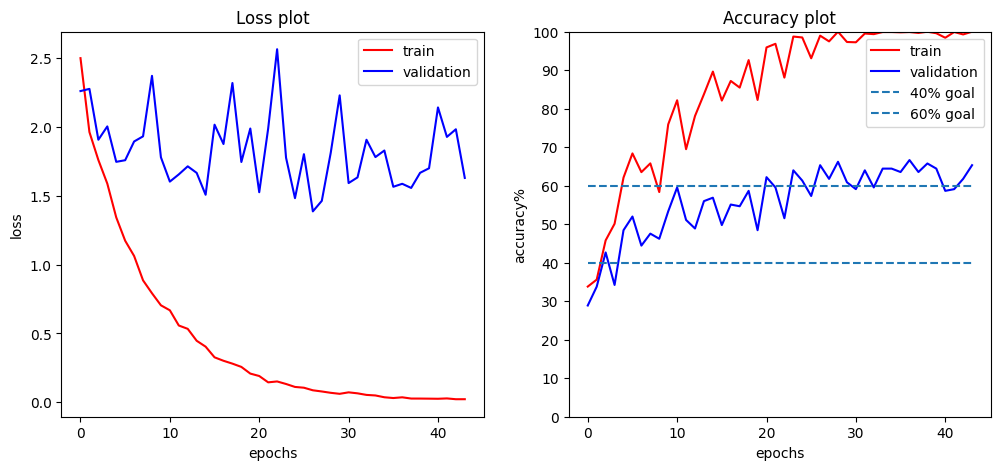

In [36]:
plot_data(losses, accuracies, goals=[40, 60])

TEST ACCURACY IS: 61.11%

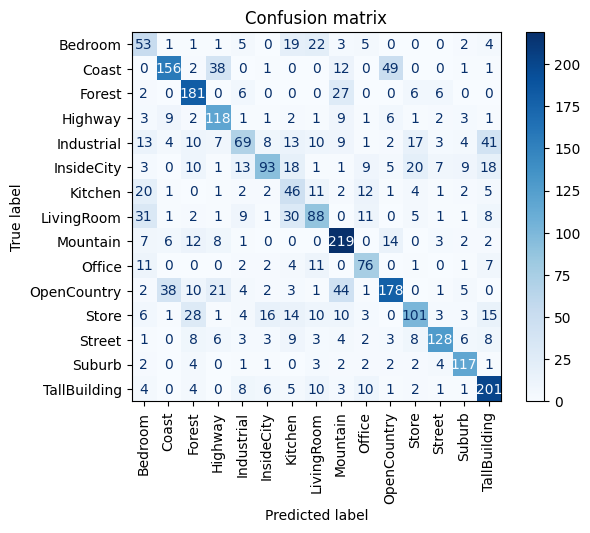

In [38]:
test_accuracy, y_hat = compute_accuracy(model, test_loader, DEVICE)

print(f'TEST ACCURACY IS: {test_accuracy/100:.2%}')
plot_confusion(test_loader.dataset[:][1], y_hat)

## Dropout

In [39]:
model = CNN(kernel_size=3, batch_norm=True, dropout=0.1)
initialize_weights(model.network)
model.to(DEVICE)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

losses, accuracies = training(model, loaders, optimizer, loss_function, num_epochs=100, early_stopper=EarlyStopping(EARLY_STOPPING), device=DEVICE)

 49%|████▉     | 49/100 [00:19<00:19,  2.57it/s]


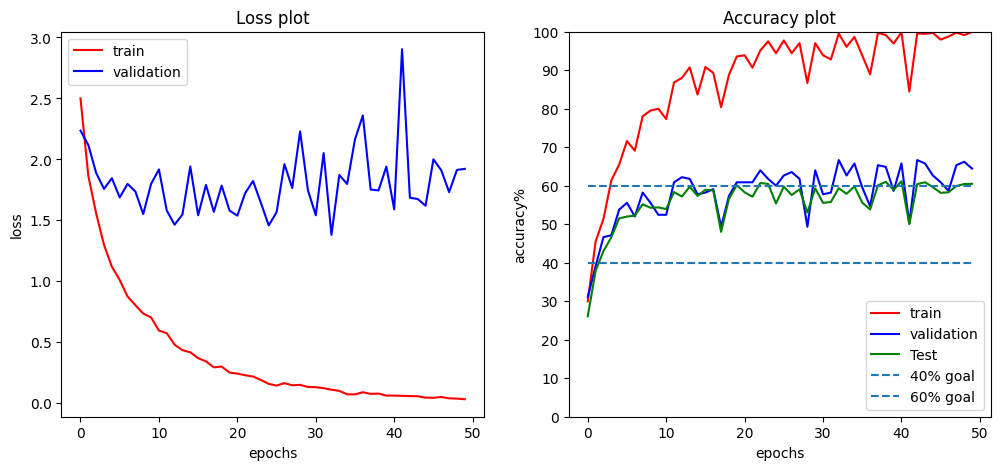

In [40]:
plot_data(losses, accuracies, goals=[40, 60], test=True)

TEST ACCURACY IS: 60.50%

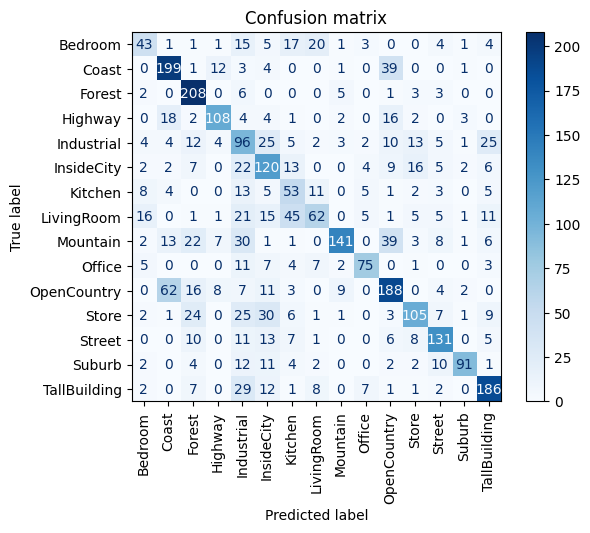

In [41]:
test_accuracy, y_hat = compute_accuracy(model, test_loader, DEVICE)

print(f'TEST ACCURACY IS: {test_accuracy/100:.2%}')
plot_confusion(test_loader.dataset[:][1], y_hat)

## Ensemble of networks

In [42]:
class Ensemble:

    def __init__(self, n, config):
        self.n = n # number of models
        self.config = config
        self.models = []
        self.device = torch.device('cpu')

        for i in range(n):
            model = CNN(**config)
            initialize_weights(model.network)
            self.models.append(model)

    def to(self, device):
        for model in self.models:
            model.to(device)
        self.device = device
    
    def train(
        self,
        loaders,
        # optimizer, 
        loss_function=nn.CrossEntropyLoss(),
        num_epochs=100,
        device=torch.device('cuda')
        ):

        data = []
        for model in self.models:
            optimizer = optim.Adam(model.parameters())

            losses, accuracies = training(model, loaders, optimizer, loss_function, num_epochs, early_stopper=EarlyStopping(EARLY_STOPPING), device=device)
            data.append([losses, accuracies])
        return data

Ensemble of 5 models

In [43]:
config = {'kernel_size': 3, "batch_norm":True, "dropout": 0.1}
e = Ensemble(5, config)
e.to(DEVICE)

data = e.train(loaders, num_epochs=100)

 34%|███▍      | 34/100 [00:13<00:25,  2.60it/s]


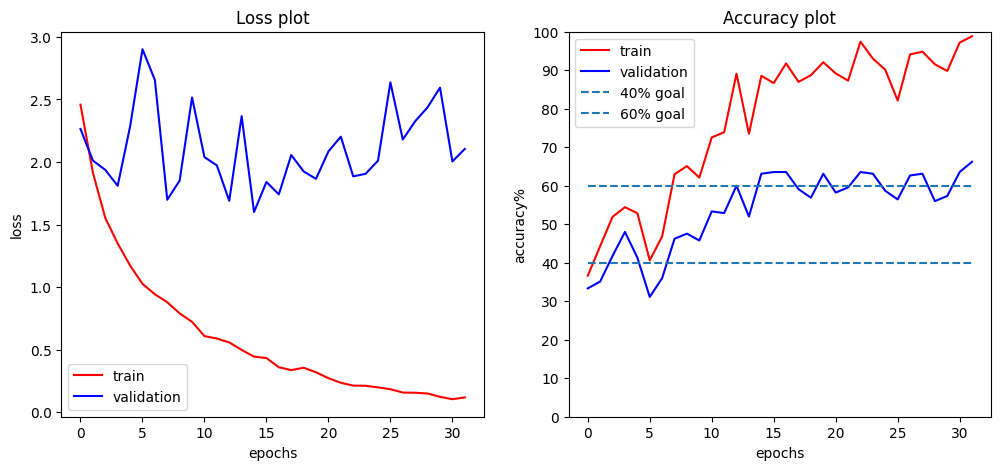

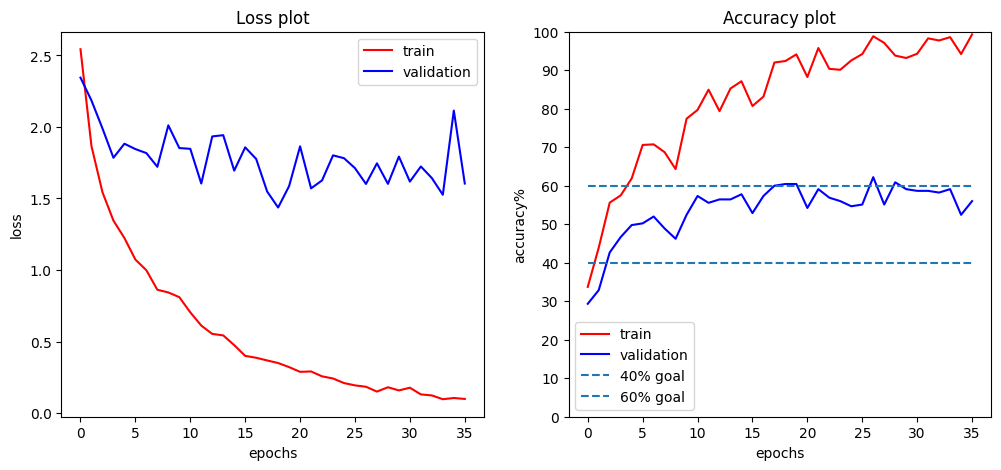

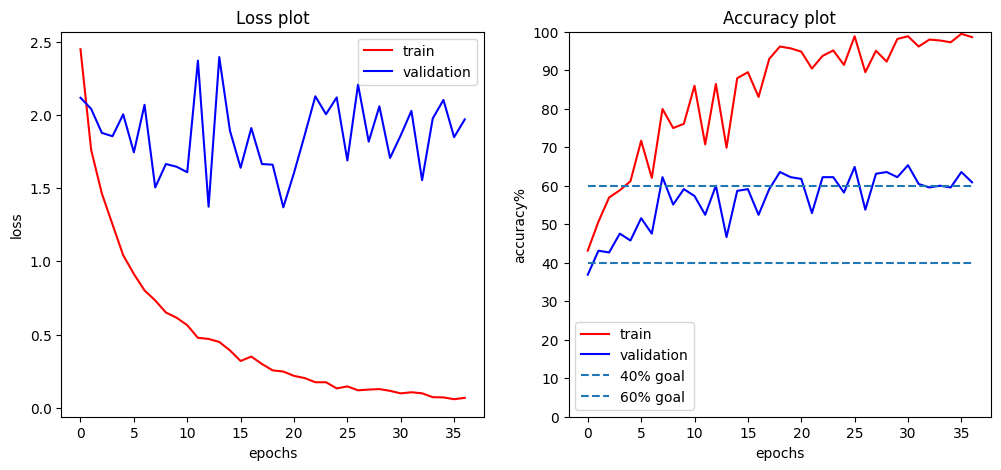

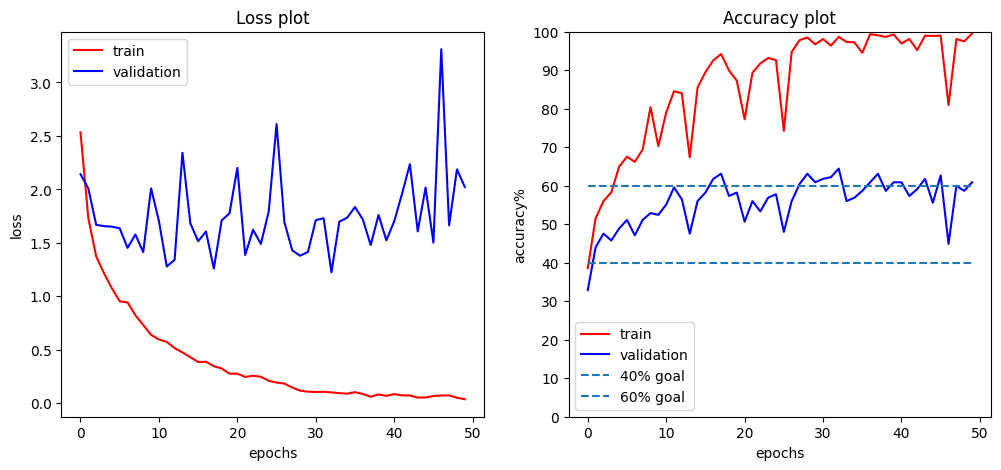

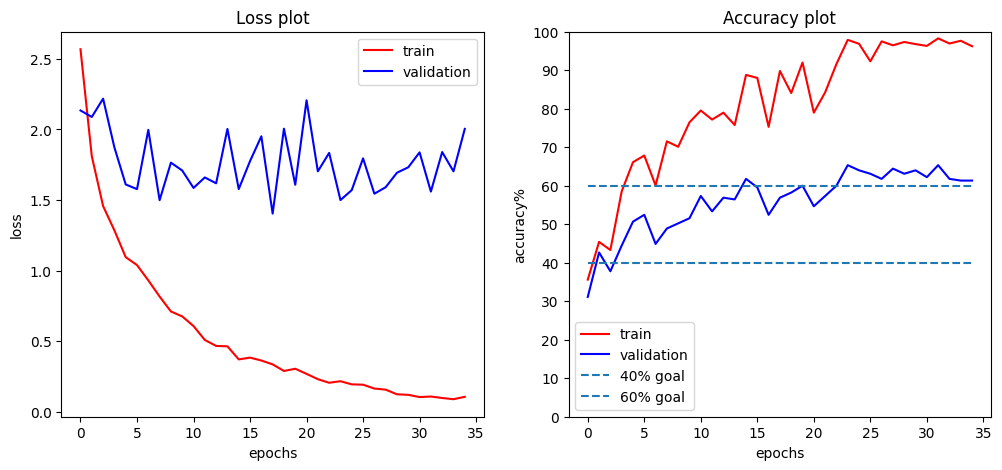

In [46]:
for i, model_data in enumerate(data):
    losses, accuracies = model_data
    plot_data(losses, accuracies, goals=[40, 60])

TEST ACCURACY IS: 63.65%

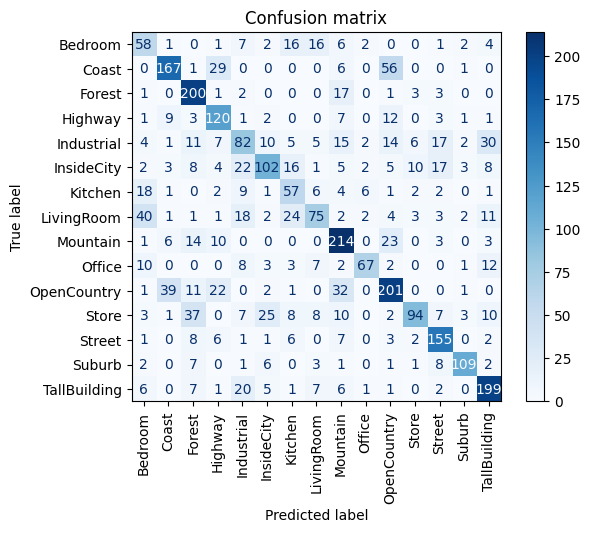

In [47]:
test_accuracy, y_hat = compute_majority_accuracy(e.models, test_loader, DEVICE)

print(f'TEST ACCURACY IS: {test_accuracy/100:.2%}')
plot_confusion(test_loader.dataset[:][1], y_hat)

Ensemble of 10 models

In [48]:
config = {'kernel_size': 3, "batch_norm":True, "dropout": 0.1}
e = Ensemble(10, config)
e.to(DEVICE)

data = e.train(loaders, num_epochs=100)

 34%|███▍      | 34/100 [00:13<00:26,  2.50it/s]


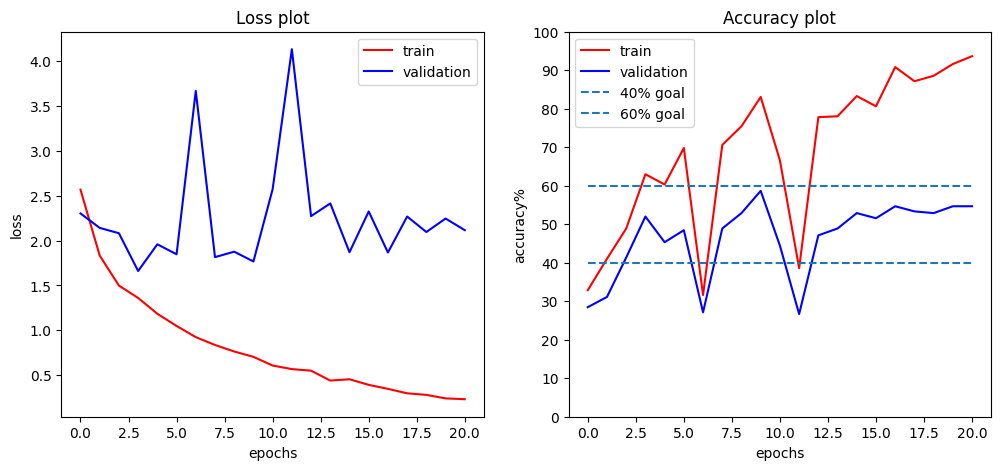

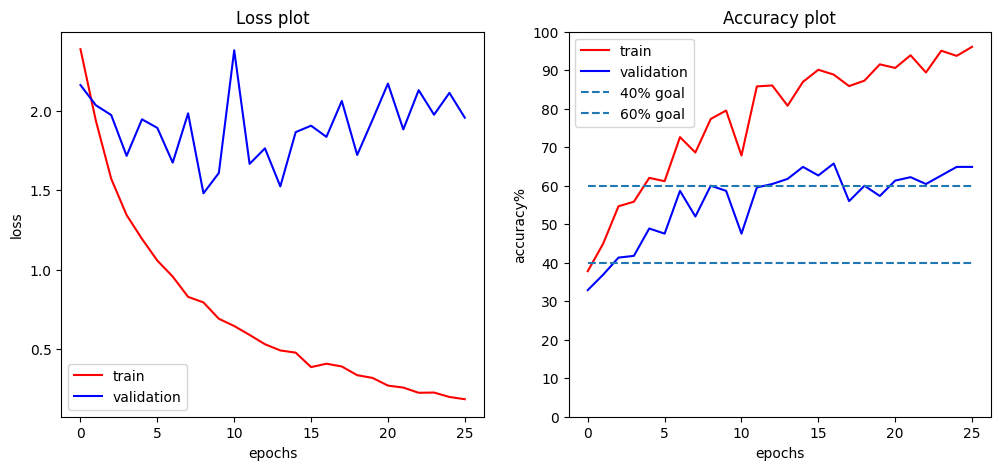

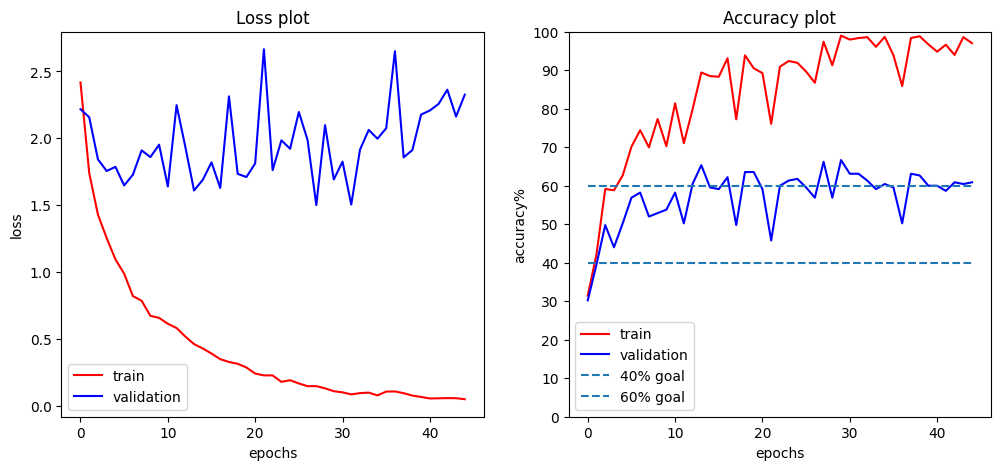

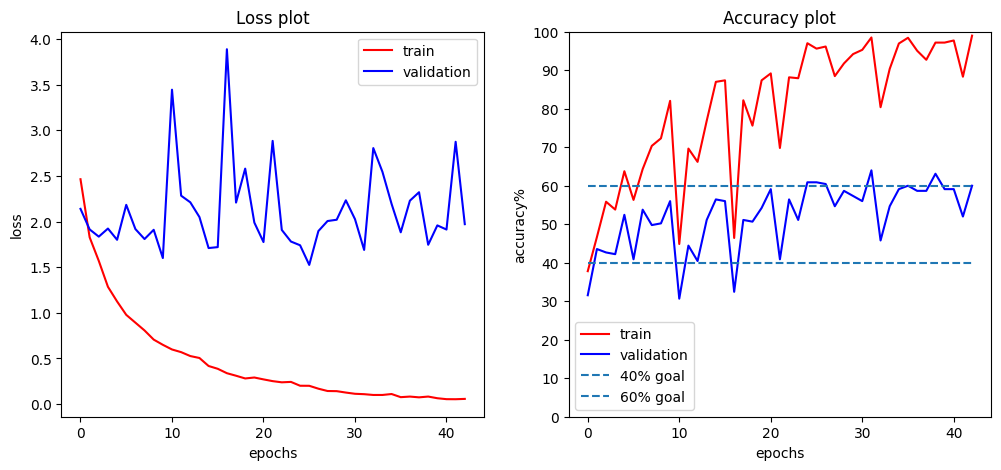

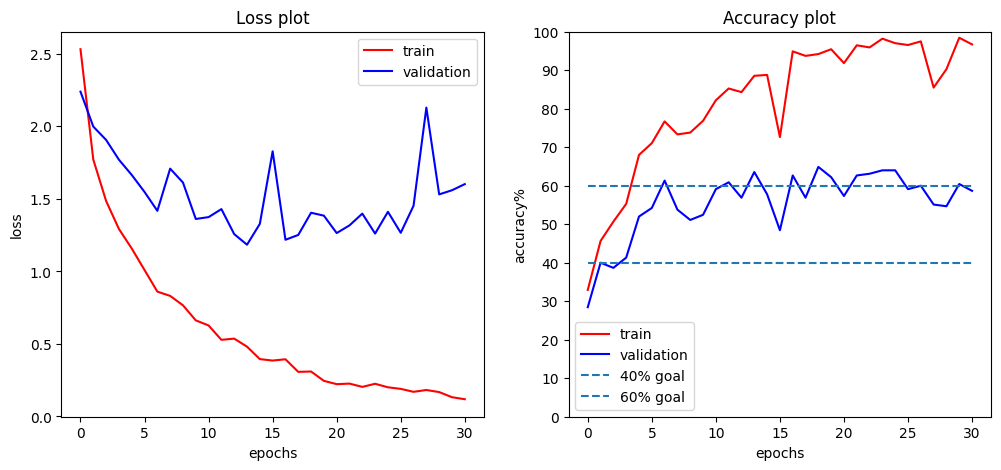

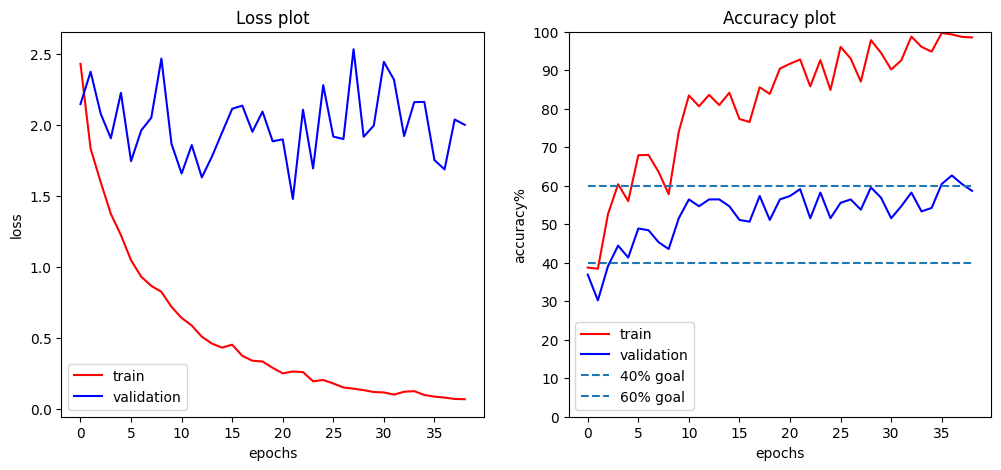

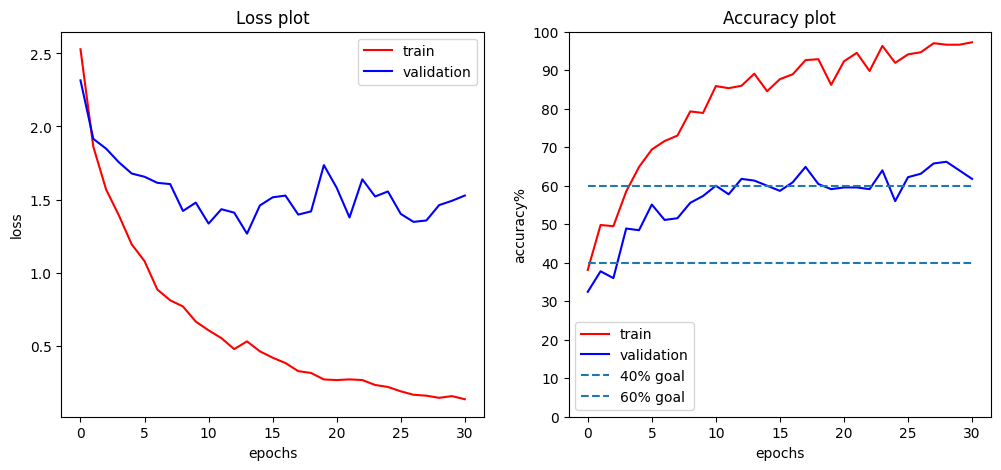

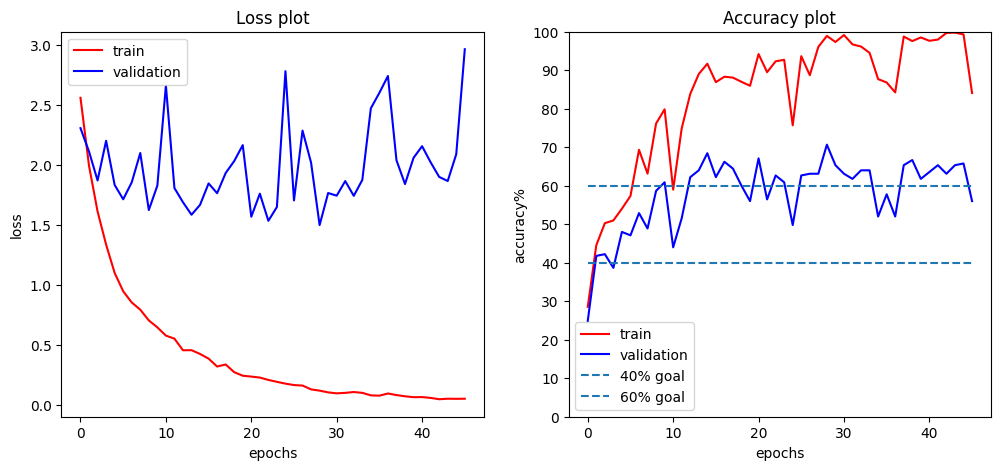

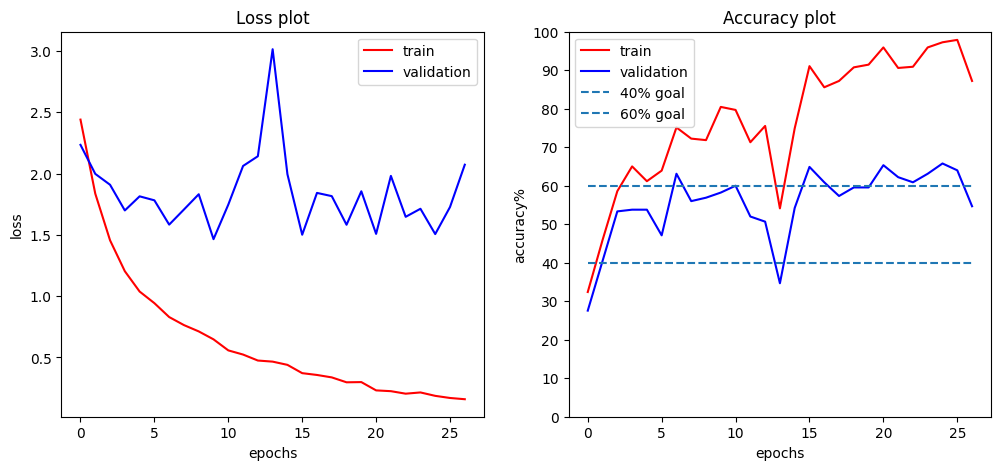

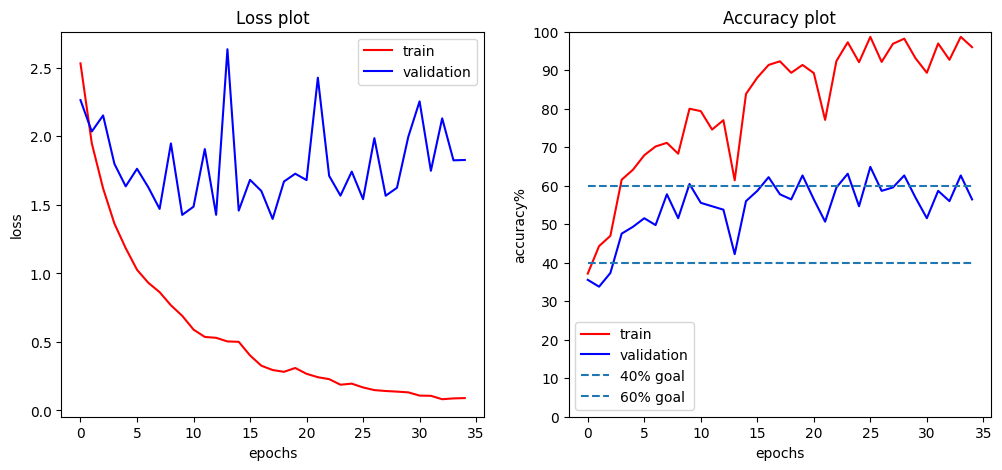

In [49]:
for i, model_data in enumerate(data):
    losses, accuracies = model_data
    plot_data(losses, accuracies, goals=[40, 60])

TEST ACCURACY IS: 64.66%

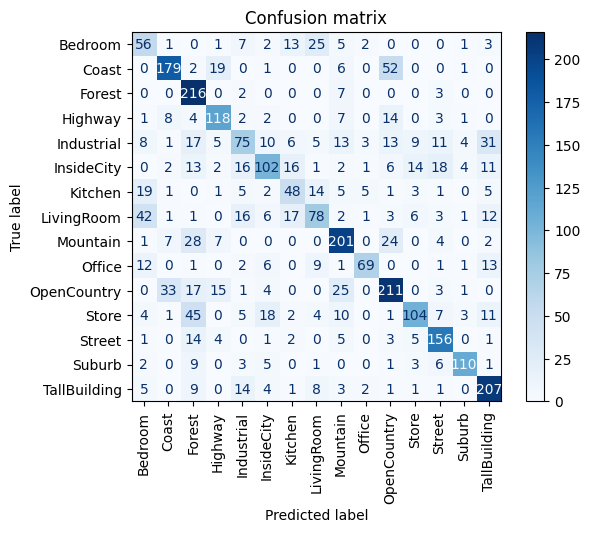

In [50]:
test_accuracy, y_hat = compute_majority_accuracy(e.models, test_loader, DEVICE)

print(f'TEST ACCURACY IS: {test_accuracy/100:.2%}')
plot_confusion(test_loader.dataset[:][1], y_hat)

# THIRD POINT

## Transfer learning

We use the pretrained alexnet, change the last layer and fine tune.

In [63]:
alex_train_loader, alex_val_loader = alex_loaders[:2]

In [64]:
# load alexnet, initialize weights, modify head

alexnet = torchvision.models.alexnet(pretrained=True)
alexnet.eval()

# freeze all layers
for param in alexnet.parameters():
    param.requires_grad = False

# unfreeze last linear layer
for param in alexnet.classifier[6].parameters():
    param.requires_grad = True

# change linear layer to adapt to 15 classes
num_final_in = alexnet.classifier[6].in_features # input dimension of final layer
alexnet.classifier[6] = nn.Linear(num_final_in, 15)
alexnet = alexnet.to(DEVICE)

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [52]:
# training of alexnet

loss_function = nn.CrossEntropyLoss()
alex_optimizer = optim.Adam(alexnet.parameters(), lr=1e-4, weight_decay=0.6)

alex_losses, alex_accuracies = training(alexnet, alex_loaders, alex_optimizer, loss_function, num_epochs=100, early_stopper=EarlyStopping(EARLY_STOPPING), device=DEVICE)

 68%|██████▊   | 68/100 [03:44<01:45,  3.31s/it]


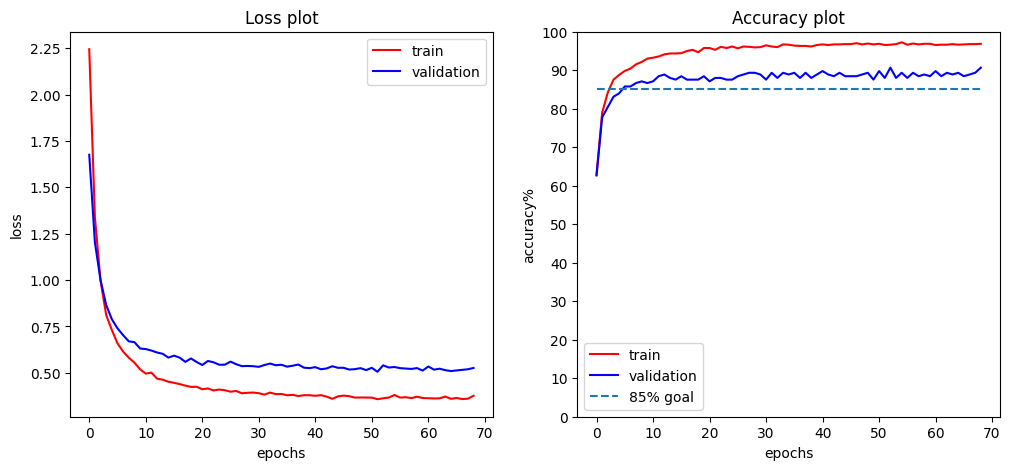

In [53]:
plot_data(alex_losses, alex_accuracies, goals=[85])

TEST ACCURACY IS: 86.56616415410386%

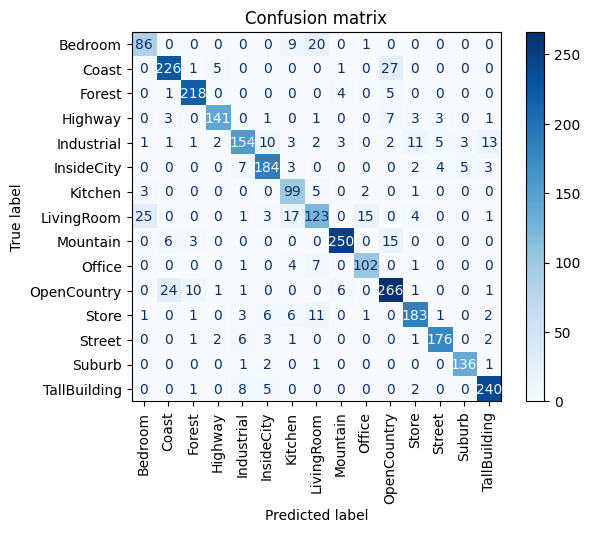

In [54]:
test_accuracy, y_hat = compute_accuracy(alexnet, alex_test_loader, DEVICE)

print(f'TEST ACCURACY IS: {test_accuracy}%')
plot_confusion(alex_test_loader.dataset[:][1], y_hat)

## SVM

First we produce a set of features using alexnet as a feature extractor

In [65]:
feature_extractor = torch.nn.Sequential(*list(alexnet.children())[:-1])
feature_extractor.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): AdaptiveAvgPool2d(output_size=(6, 6))
)

In [66]:
# build dataset for SVM

svm_X_train, svm_y_train = build_svm_features(feature_extractor, alex_train_loader, DEVICE)
svm_X_val, svm_y_val = build_svm_features(feature_extractor, alex_val_loader, DEVICE)
svm_X_test, svm_y_test = build_svm_features(feature_extractor, alex_test_loader, DEVICE)

#### OVO

One-vs-One approach with linear kernel

TEST ACCURACY IS 86.30%

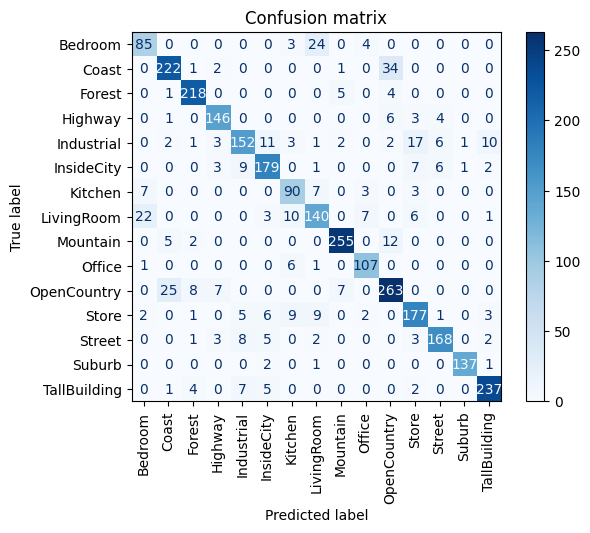

In [ ]:
linear_svm_ovo = SVC(kernel='linear')
linear_svm_ovo.fit(svm_X_train, svm_y_train)
predictions = linear_svm_ovo.predict(svm_X_test)

print(f'TEST ACCURACY IS {accuracy_score(svm_y_test, predictions):.2%}')

plot_confusion(svm_y_test, predictions)

#### OVA

One-vs-All approache with linear kernel

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


TEST ACCURACY IS 84.72%

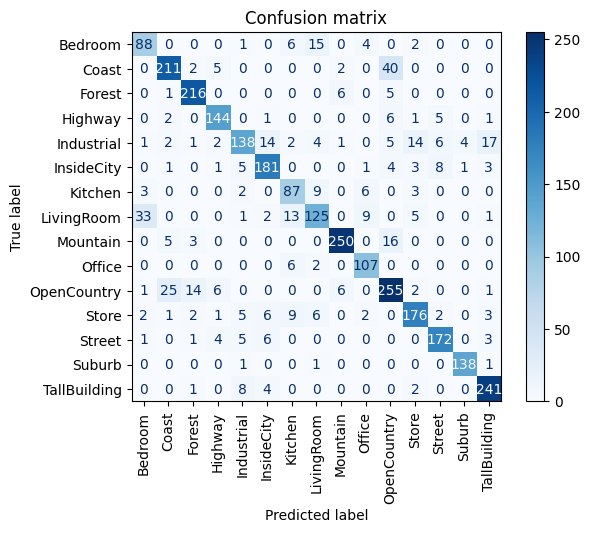

In [ ]:
linear_svm_ova = LinearSVC()
linear_svm_ova.fit(svm_X_train, svm_y_train)
predictions = linear_svm_ova.predict(svm_X_test)

print(f'TEST ACCURACY IS {accuracy_score(svm_y_test, predictions):.2%}')

plot_confusion(svm_y_test, predictions)

# FIFTH POINT

more convolutional layers

In [ ]:
model = CNN(kernel_size=3, batch_norm=True, dropout=0.1, add_conv=True)
initialize_weights(model.network)
model.to(DEVICE)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

losses, accuracies = training(model, loaders, optimizer, loss_function, num_epochs=100, early_stopper=EarlyStopping(EARLY_STOPPING), device=DEVICE)

In [ ]:
plot_data(losses, accuracies, goals=[40, 60])

In [ ]:
test_accuracy, y_hat = compute_accuracy(model, test_loader, DEVICE)

print(f'TEST ACCURACY IS: {test_accuracy/100:.2%}')
plot_confusion(test_loader.dataset[:][1], y_hat)

An additional linear layer

In [ ]:
model = CNN(kernel_size=3, batch_norm=True, dropout=0.1, add_linear=True)
initialize_weights(model.network)
model.to(DEVICE)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

losses, accuracies = training(model, loaders, optimizer, loss_function, num_epochs=100, early_stopper=EarlyStopping(EARLY_STOPPING), device=DEVICE)

In [ ]:
plot_data(losses, accuracies, goals=[40, 60])

In [ ]:
test_accuracy, y_hat = compute_accuracy(model, test_loader, DEVICE)

print(f'TEST ACCURACY IS: {test_accuracy/100:.2%}')
plot_confusion(test_loader.dataset[:][1], y_hat)

Add both an additional convolutional block and linear layer

In [ ]:
model = CNN(kernel_size=3, batch_norm=True, dropout=0.1, add_conv=True, add_conv=True)
initialize_weights(model.network)
model.to(DEVICE)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

losses, accuracies = training(model, loaders, optimizer, loss_function, num_epochs=100, early_stopper=EarlyStopping(EARLY_STOPPING), device=DEVICE)

In [ ]:
plot_data(losses, accuracies, goals=[40, 60])

In [ ]:
test_accuracy, y_hat = compute_accuracy(model, test_loader, DEVICE)

print(f'TEST ACCURACY IS: {test_accuracy/100:.2%}')
plot_confusion(test_loader.dataset[:][1], y_hat)

## SIXTH POINT

We implement One-vs-One multiclass SVM with gaussian kernel

TEST ACCURACY IS 85.46%

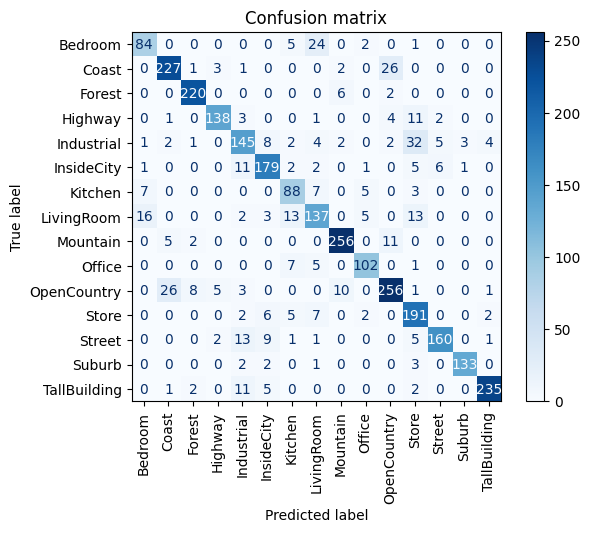

In [ ]:
gaussian_svm_ovo = SVC(kernel='rbf')
gaussian_svm_ovo.fit(svm_X_train, svm_y_train)
predictions = gaussian_svm_ovo.predict(svm_X_test)

print(f'TEST ACCURACY IS {accuracy_score(svm_y_test, predictions):.2%}')

plot_confusion(svm_y_test, predictions)

## SEVENTH POINT

Implementation of Erroc Correcting Output Code with gaussian svm. We try to code sizes:
- 1.5 requires more classifiers than OVA
- 0.5 requires less classifiers

ECOC version 0.5

TEST ACCURACY IS 75.14%

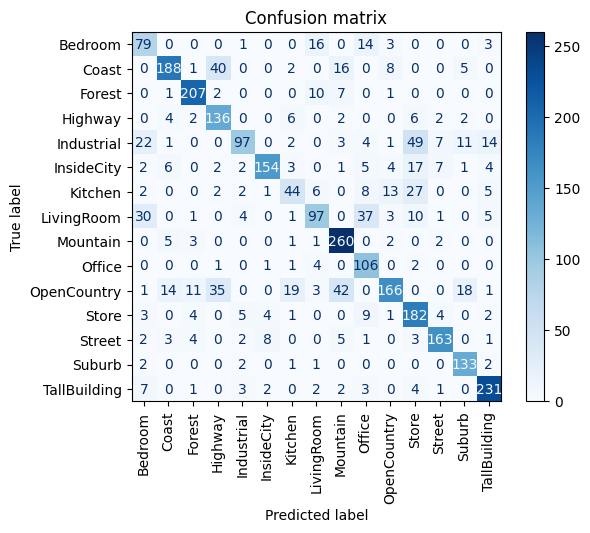

In [67]:
svm = SVC(kernel='rbf')
ecoc = OutputCodeClassifier(estimator=svm, code_size=0.5)

ecoc.fit(svm_X_train, svm_y_train)

predictions = ecoc.predict(svm_X_test)
accuracy = accuracy_score(svm_y_test, predictions)
print(f'TEST ACCURACY IS {accuracy:.2%}')
plot_confusion(svm_y_test, predictions)
#approx = 2:27

ECOC version 1.5

In [ ]:
svm = SVC(kernel='rbf')
ecoc = OutputCodeClassifier(estimator=svm, code_size=4)

ecoc.fit(svm_X_train, svm_y_train)

predictions = ecoc.predict(svm_X_test)
accuracy = accuracy_score(svm_y_test, predictions)
print(f'TEST ACCURACY IS {accuracy:.2%}')
plot_confusion(svm_y_test, predictions)